In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [33]:
TRAIN_SEGMENT = 1
TEST_SEGMENT = 1

In [34]:
train_df = pd.read_csv(f'../dataset/preprocessed-training-data/power-laws-forecasting-energy-consumption-preprocessed-training-data-split_{TRAIN_SEGMENT}.csv')
test_df = pd.read_csv(f'../dataset/preprocessed-test-data/power-laws-forecasting-energy-consumption-preprocessed-test-data-split_{TEST_SEGMENT}.csv')
train_df
test_df

,obs_id,SiteId,Timestamp,ForecastId,Value,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,...,Distance_3,Distance_4,DateInWeek,Time,Hour,TimeInterval,PartOfDay,Year,Month,Season
0,2,119,2015-01-05 18:30:00+00:00,2378,1971.344365,18648.464511,15.0,18.0,False,False,...,0.0,0.0,Monday,18:30:00,18,18-19,Afternoon,2015,1,Winter
1,3,112,2015-11-08 15:30:00+00:00,2276,876.615143,8554.793631,15.0,18.0,False,False,...,0.0,0.0,Sunday,15:30:00,15,15-16,Afternoon,2015,11,Autumn
2,4,22,2016-06-17 17:10:00+00:00,703,15091.513995,7392.365415,10.0,18.0,False,False,...,0.0,0.0,Friday,17:10:00,17,17-18,Afternoon,2016,6,Summer
3,11,302,2013-01-11 18:30:00+00:00,6821,45430.633875,21284.578622,15.0,18.0,False,False,...,0.0,0.0,Friday,18:30:00,18,18-19,Afternoon,2013,1,Winter
4,27,6,2013-04-18 17:45:00+00:00,51,43082.633137,9150.195373,30.0,18.0,False,False,...,0.0,0.0,Thursday,17:45:00,17,17-18,Afternoon,2013,4,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1825416,8,2015-10-04 07:15:00+00:00,267,19273.338819,22221.851847,30.0,18.0,False,False,...,0.0,0.0,Sunday,07:15:00,7,7-8,Morning,2015,10,Autumn
299996,1825419,178,2017-01-18 02:00:00+00:00,3608,4144.554985,1439.936818,15.0,18.0,False,False,...,0.0,0.0,Wednesday,02:00:00,2,2-3,Night,2017,1,Winter
299997,1825421,237,2013-07-23 19:15:00+00:00,5117,3875.856202,9084.382914,15.0,18.0,False,False,...,0.0,0.0,Tuesday,19:15:00,19,19-20,Evening,2013,7,Summer
299998,1825424,84,2015-11-28 22:25:00+00:00,1664,3513.128717,2775.127719,5.0,18.0,False,False,...,0.0,0.0,Saturday,22:25:00,22,22-23,Evening,2015,11,Autumn


In [35]:
train_df = pd.get_dummies(train_df, columns=['DateInWeek', 'Holiday'])
test_df = pd.get_dummies(test_df, columns=['DateInWeek', 'Holiday'])
def label_encoding(x):
    help = {
        'Morning': 0,
        'Afternoon': 1,
        'Evening': 2,
        'Night': 3,
        'Spring': 0,
        'Summer': 1,
        'Autumn': 2,
        'Winter': 3
    }
    return help[x]

train_df['PartOfDay'] = train_df['PartOfDay'].apply(label_encoding)
test_df['PartOfDay'] = test_df['PartOfDay'].apply(label_encoding)
train_df['Season'] = train_df['Season'].apply(label_encoding)
test_df['Season'] = test_df['Season'].apply(label_encoding)
train_df.columns
#test_df.columns

Index(['obs_id', 'SiteId', 'Timestamp', 'ForecastId', 'Value', 'Surface',
       'Sampling', 'BaseTemperature', 'MondayIsDayOff', 'TuesdayIsDayOff',
       'WednesdayIsDayOff', 'ThursdayIsDayOff', 'FridayIsDayOff',
       'SaturdayIsDayOff', 'SundayIsDayOff', 'ForecastPeriodNS', 'Date',
       'Temperature_1', 'Temperature_2', 'Temperature_3', 'Temperature_4',
       'Distance_1', 'Distance_2', 'Distance_3', 'Distance_4', 'Time', 'Hour',
       'TimeInterval', 'PartOfDay', 'Year', 'Month', 'Season',
       'DateInWeek_Friday', 'DateInWeek_Monday', 'DateInWeek_Saturday',
       'DateInWeek_Sunday', 'DateInWeek_Thursday', 'DateInWeek_Tuesday',
       'DateInWeek_Wednesday'],
      dtype='object')

In [36]:
attributes = [i for i in range(1, 39) if i not in [2, 3, 4, 6, 15, 16, 25, 26, 27, 30]]
training_data = train_df.values
test_data = test_df.values
training_data = training_data[:, attributes + [4]]
test_data = test_data[:, attributes + [4]]


z_scores = np.abs((training_data - training_data.mean()) / training_data.std())

threshold = 3.0

training_data = training_data[(z_scores < threshold).all(axis=1)]

z_scores = np.abs((test_data - test_data.mean()) / test_data.std())

test_data = test_data[(z_scores < threshold).all(axis=1)]

num_trains = 100000 

X_train = training_data[:num_trains, :-1]
y_train = training_data[:num_trains, -1]
X_test = test_data[:num_trains//5, :-1]
y_test = test_data[:num_trains//5, -1]
y_train
# X_test

array([289058.7310294288, 37873.175382503534, 97.72089583543128, ...,
       3154.2449275963013, 1626.2221152368002, 10664.834396839142],
      dtype=object)

In [37]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train
X_test

array([[0.38613861, 0.26024201, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3630363 , 0.11927086, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0660066 , 0.10303605, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03960396, 0.00959788, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.72277228, 0.13247337, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.52805281, 0.02346435, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [38]:
lin_regressor = LinearRegression()
svm_regressor = SVR(kernel='rbf', C=10, epsilon=24)
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=24)
grdb_regressor = GradientBoostingRegressor(n_estimators=500, max_depth=10, min_samples_split=5, learning_rate=0.01, loss='squared_error')

lin_regressor.fit(X_train, y_train)
svm_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
grdb_regressor.fit(X_train, y_train)


y_pred_lin = lin_regressor.predict(X_test)
y_pred_svm = svm_regressor.predict(X_test)
y_pred_rf = rf_regressor.predict(X_test)
y_pred_grdb = grdb_regressor.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin) 
mae_svm = mean_absolute_error(y_test, y_pred_svm) 
mae_rf = mean_absolute_error(y_test, y_pred_rf) 
mae_grdb = mean_absolute_error(y_test, y_pred_grdb) 

mse_lin = mean_squared_error(y_test, y_pred_lin) 
mse_svm = mean_squared_error(y_test, y_pred_svm) 
mse_rf = mean_squared_error(y_test, y_pred_rf) 
mse_grdb = mean_squared_error(y_test, y_pred_grdb) 

rmse_lin = math.sqrt(mse_lin)
rmse_svm = math.sqrt(mse_svm)
rmse_rf = math.sqrt(mse_rf) 
rmse_grdb = math.sqrt(mse_grdb) 

r2_lin = r2_score(y_test, y_pred_lin)
r2_svm = r2_score(y_test, y_pred_svm)
r2_rf = r2_score(y_test, y_pred_rf)
r2_grdb = r2_score(y_test, y_pred_grdb)


print(f"Mean Absolute Error (Linear Regression): {round(mae_lin,4)}")
print(f"Mean Squared Error (Linear Regression): {round(mse_lin,4)}")
print(f"Root Mean Squared Error (Linear Regression): {round(rmse_lin,4)}")
print(f"R-squared (Linear Regression): {round(r2_lin,4)}\n")

print(f"Mean Absolute Error (SVM): {round(mae_svm,4)}")
print(f"Mean Squared Error (SVM): {round(mse_svm,4)}")
print(f"Root Mean Squared Error (SVM): {round(rmse_svm,4)}")
print(f"R-squared (SVM): {round(r2_svm,4)}\n")


print(f"Mean Absolute Error (RF): {round(mae_rf,4)}")
print(f"Mean Squared Error (RF): {round(mse_rf,4)}")
print(f"Root Mean Squared Error (RF): {round(rmse_rf,4)}")
print(f"R-squared (RF): {round(r2_rf,4)}\n")

print(f"Mean Absolute Error (GRDB): {round(mae_grdb,4)}")
print(f"Mean Squared Error (GRDB): {round(mse_grdb,4)}")
print(f"Root Mean Squared Error (GRDB): {round(rmse_grdb,4)}")
print(f"R-squared (GRDB): {round(r2_grdb,4)}")


Mean Absolute Error (Linear Regression): 30085.3981
Mean Squared Error (Linear Regression): 3626850479.5889
Root Mean Squared Error (Linear Regression): 60223.3383
R-squared (Linear Regression): 0.0709

Mean Absolute Error (SVM): 31646.7601
Mean Squared Error (SVM): 4334752429.9742
Root Mean Squared Error (SVM): 65838.8368
R-squared (SVM): -0.1104

Mean Absolute Error (RF): 8931.2573
Mean Squared Error (RF): 503040447.4369
Root Mean Squared Error (RF): 22428.5632
R-squared (RF): 0.8711

Mean Absolute Error (GRDB): 9699.1912
Mean Squared Error (GRDB): 503641105.3242
Root Mean Squared Error (GRDB): 22441.9497
R-squared (GRDB): 0.871


In [39]:
y_train_pred_lin = lin_regressor.predict(X_train)
y_train_pred_rf = rf_regressor.predict(X_train)
y_train_pred_svm = svm_regressor.predict(X_train)
y_train_pred_grdb = grdb_regressor.predict(X_train)

mae_lin_train = mean_absolute_error(y_train, y_train_pred_lin) 
mae_svm_train = mean_absolute_error(y_train, y_train_pred_svm) 
mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf) 
mae_grdb_train = mean_absolute_error(y_train, y_train_pred_grdb) 

mse_lin_train = mean_squared_error(y_train, y_train_pred_lin) 
mse_svm_train = mean_squared_error(y_train, y_train_pred_svm)
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf) 
mse_grdb_train = mean_squared_error(y_train, y_train_pred_grdb) 

rmse_lin_train = math.sqrt(mse_lin_train) 
rmse_svm_train = math.sqrt(mse_svm_train) 
rmse_rf_train = math.sqrt(mse_rf_train) 
rmse_grdb_train = math.sqrt(mse_grdb_train) 

r2_lin_train = r2_score(y_train, y_train_pred_lin)
r2_svm_train = r2_score(y_train, y_train_pred_svm)
r2_rf_train = r2_score(y_train, y_train_pred_rf)
r2_grdb_train = r2_score(y_train, y_train_pred_grdb)

print("Đánh Giá Trên Tập Huấn Luyện:")
print("Linear Regression - Mean Absolute Error (MAE):", mae_lin_train)
print("Linear Regression - Mean Squared Error (MSE):", mse_lin_train)
print("Linear Regression - Root Mean Squared Error (RMSE):", rmse_lin_train)
print("Linear Regression - R-squared (R2):", r2_lin_train)

print("\nSVM - Mean Absolute Error (MAE):", mae_svm_train)
print("SVM - Mean Squared Error (MSE):", mse_svm_train)
print("SVM - Root Mean Squared Error (RMSE):", rmse_svm_train)
print("SVM - R-squared (R2):", r2_svm_train)

print("\nRandom Forest - Mean Absolute Error (MAE):", mae_rf_train)
print("Random Forest - Mean Squared Error (MSE):", mse_rf_train)
print("Random Forest - Root Mean Squared Error (RMSE):", rmse_rf_train)
print("Random Forest - R-squared (R2):", r2_rf_train)

print(f"\nMean Absolute Error (GRDB): {mae_grdb_train}")
print(f"Mean Squared Error (GRDB): {mse_grdb_train}")
print(f"Root Mean Squared Error (GRDB): {rmse_grdb_train}")
print(f"R-squared (GRDB): {r2_grdb_train}")


print("\nĐánh Giá Trên Tập Kiểm Thử:")
print("Linear Regression - Mean Absolute Error (MAE):", mae_lin)
print("Linear Regression - Mean Squared Error (MSE):", mse_lin)
print("Linear Regression - Root Mean Squared Error (RMSE):", rmse_lin)
print("Linear Regression - R-squared (R2):", r2_lin)

print("\nSVM - Mean Absolute Error (MAE):", mae_svm)
print("SVM - Mean Squared Error (MSE):", mse_svm)
print("SVM - Root Mean Squared Error (RMSE):", rmse_svm)
print("SVM - R-squared (R2):", r2_svm)

print("\nRandom Forest - Mean Absolute Error (MAE):", mae_rf)
print("Random Forest - Mean Squared Error (MSE):", mse_rf)
print("Random Forest - Root Mean Squared Error (RMSE):", rmse_rf)
print("Random Forest - R-squared (R2):", r2_rf)

print(f"\nMean Absolute Error (GRDB): {mae_grdb}")
print(f"Mean Squared Error (GRDB): {mse_grdb}")
print(f"Root Mean Squared Error (GRDB): {rmse_grdb}")
print(f"R-squared (GRDB): {r2_grdb}")

Đánh Giá Trên Tập Huấn Luyện:
Linear Regression - Mean Absolute Error (MAE): 33477.40232129207
Linear Regression - Mean Squared Error (MSE): 3170071392.45689
Linear Regression - Root Mean Squared Error (RMSE): 56303.387042494076
Linear Regression - R-squared (R2): 0.14425121010615694

SVM - Mean Absolute Error (MAE): 31811.6170977446
SVM - Mean Squared Error (MSE): 4146009154.745765
SVM - Root Mean Squared Error (RMSE): 64389.51121685709
SVM - R-squared (R2): -0.11919949989288203

Random Forest - Mean Absolute Error (MAE): 5578.845274312792
Random Forest - Mean Squared Error (MSE): 183803096.07769305
Random Forest - Root Mean Squared Error (RMSE): 13557.400048596819
Random Forest - R-squared (R2): 0.9503830489680789

Mean Absolute Error (GRDB): 8692.811564642656
Mean Squared Error (GRDB): 322677078.3360906
Root Mean Squared Error (GRDB): 17963.214588043273
R-squared (GRDB): 0.9128945423848698

Đánh Giá Trên Tập Kiểm Thử:
Linear Regression - Mean Absolute Error (MAE): 30085.398059088446

In [40]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

svm_mae_scores = []
rf_mae_scores = []
grdb_mae_scores = []
lin_mae_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    
    svm_regressor.fit(X_train_fold, y_train_fold)
    y_pred_svm = svm_regressor.predict(X_test_fold)
    svm_mae_scores.append(mean_absolute_error(y_test_fold, y_pred_svm))
    
    
    rf_regressor.fit(X_train_fold, y_train_fold)
    y_pred_rf = rf_regressor.predict(X_test_fold)
    rf_mae_scores.append(mean_absolute_error(y_test_fold, y_pred_rf))
    
    
    grdb_regressor.fit(X_train_fold, y_train_fold)
    y_pred_grdb = grdb_regressor.predict(X_test_fold)
    grdb_mae_scores.append(mean_absolute_error(y_test_fold, y_pred_grdb))

    lin_regressor.fit(X_train_fold, y_train_fold)
    y_pred_lin = lin_regressor.predict(X_test_fold)
    lin_mae_scores.append(mean_absolute_error(y_test_fold, y_pred_lin))


svm_avg_mae = np.mean(svm_mae_scores)
rf_avg_mae = np.mean(rf_mae_scores)
grdb_avg_mae = np.mean(grdb_mae_scores)
lin_avg_mae = np.mean(lin_mae_scores)

print(f"Trung bình MAE của Linear Regression qua {num_folds} fold: {lin_avg_mae}")
print(f"Trung bình MAE của SVM qua {num_folds} fold: {svm_avg_mae}")
print(f"Trung bình MAE của Random Forest qua {num_folds} fold: {rf_avg_mae}")
print(f"Trung bình MAE của Gradient Boosting qua {num_folds} fold: {grdb_avg_mae}")

Trung bình MAE của Linear Regression qua 5 fold: 33517.6534456023
Trung bình MAE của SVM qua 5 fold: 31919.46715220785
Trung bình MAE của Random Forest qua 5 fold: 8724.065868392743
Trung bình MAE của Gradient Boosting qua 5 fold: 9703.863126513705


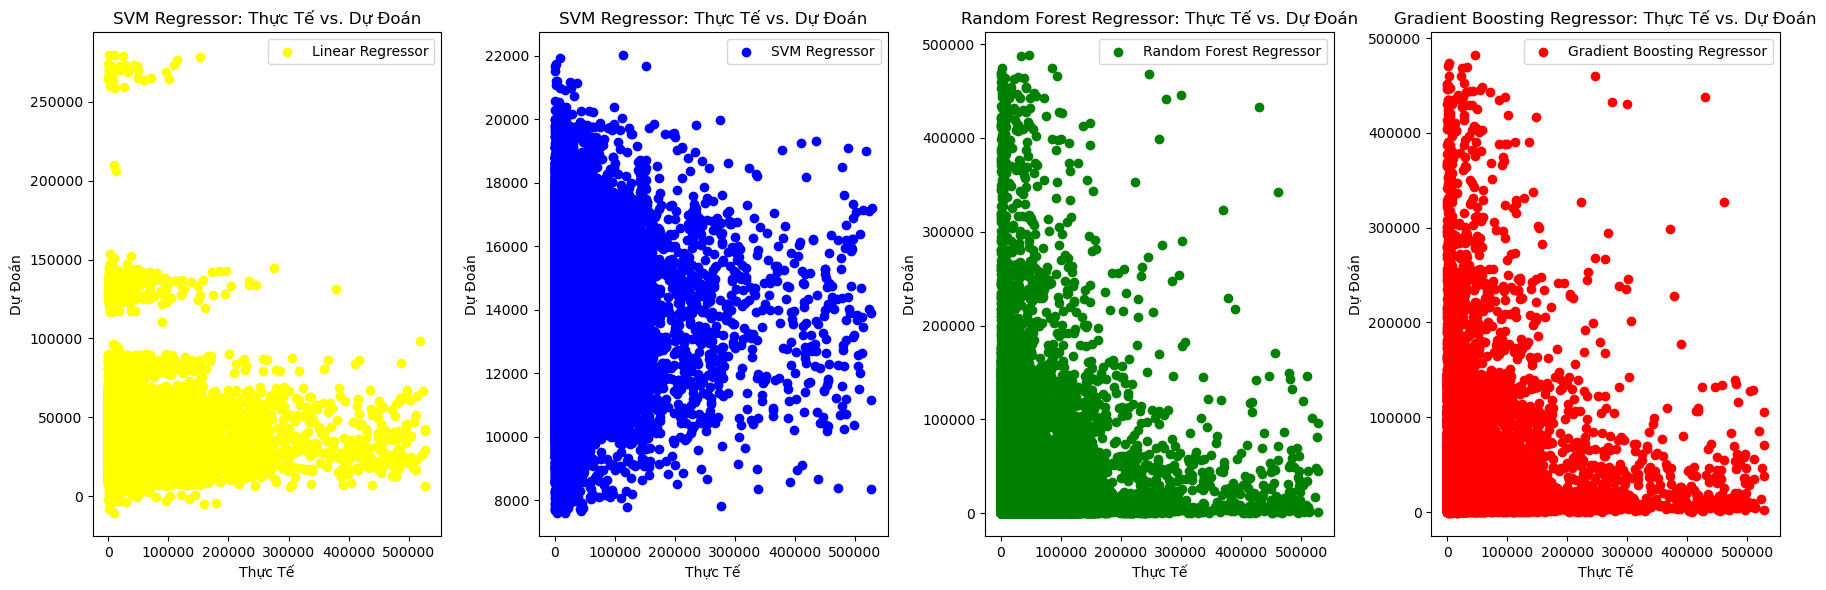

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.scatter(y_test, y_pred_lin, color='yellow', label='Linear Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('SVM Regressor: Thực Tế vs. Dự Đoán')
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_svm, color='blue', label='SVM Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('SVM Regressor: Thực Tế vs. Dự Đoán')
plt.legend()

plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Random Forest Regressor: Thực Tế vs. Dự Đoán')
plt.legend()


plt.subplot(1, 4, 4)
plt.scatter(y_test, y_pred_grdb, color='red', label='Gradient Boosting Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Gradient Boosting Regressor: Thực Tế vs. Dự Đoán')
plt.legend()

plt.tight_layout()
plt.show()

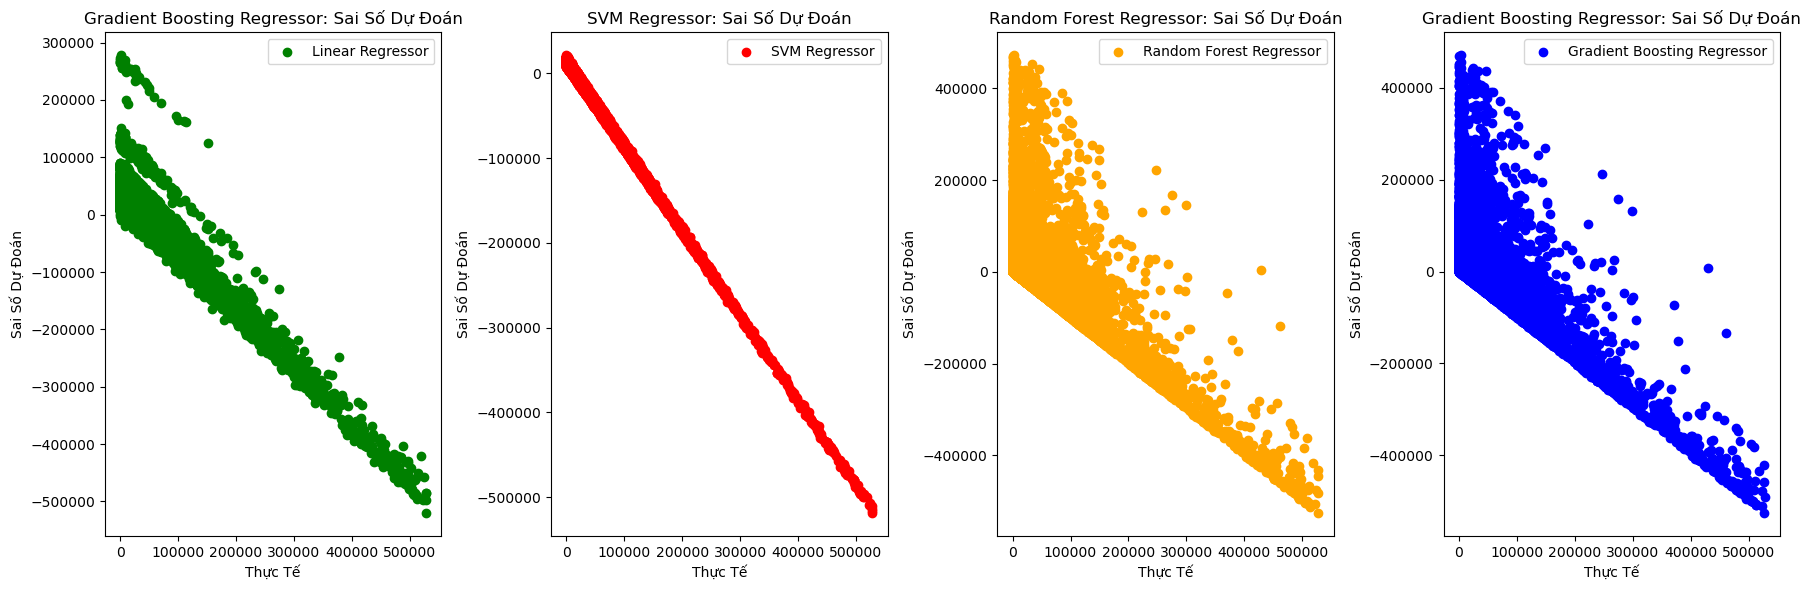

In [42]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.scatter(y_test, y_pred_lin - y_test, color='green', label='Linear Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Sai Số Dự Đoán')
plt.title('Gradient Boosting Regressor: Sai Số Dự Đoán')
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_svm - y_test, color='red', label='SVM Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Sai Số Dự Đoán')
plt.title('SVM Regressor: Sai Số Dự Đoán')
plt.legend()

plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_rf - y_test, color='orange', label='Random Forest Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Sai Số Dự Đoán')
plt.title('Random Forest Regressor: Sai Số Dự Đoán')
plt.legend()

plt.subplot(1, 4, 4)
plt.scatter(y_test, y_pred_grdb - y_test, color='blue', label='Gradient Boosting Regressor')
plt.xlabel('Thực Tế')
plt.ylabel('Sai Số Dự Đoán')
plt.title('Gradient Boosting Regressor: Sai Số Dự Đoán')
plt.legend()


plt.tight_layout()
plt.show()

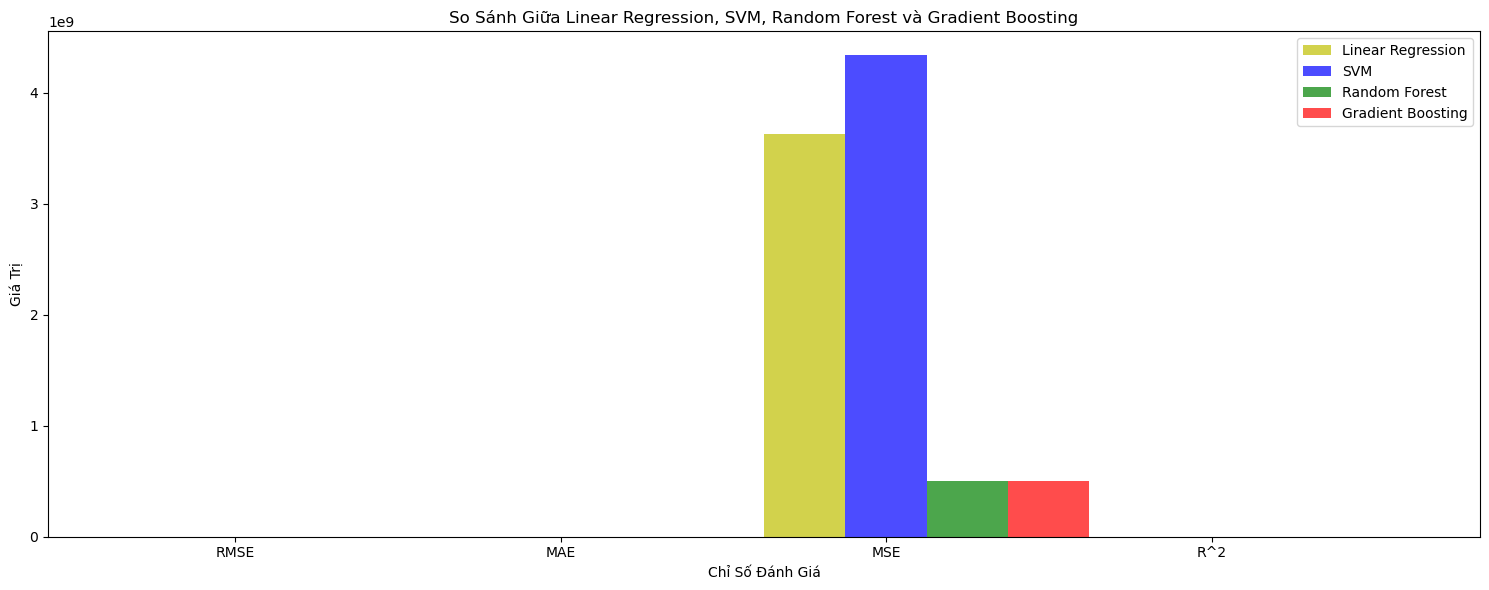

In [43]:
import matplotlib.pyplot as plt
import numpy as np

evaluation_metrics = ['RMSE', 'MAE', 'MSE', 'R^2']
svm_scores = [rmse_svm, mae_svm, mse_svm, r2_svm*100]
rf_scores = [rmse_rf, mae_rf, mse_rf, r2_rf*100]
grdb_scores = [rmse_grdb, mae_grdb, mse_grdb, r2_grdb*100]
lin_scores = [rmse_lin, mae_lin, mse_lin, r2_lin*100]

bar_width = 0.25
r1 = np.arange(len(lin_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(15, 6))

plt.bar(r1, lin_scores, width=bar_width, label='Linear Regression', color='y', alpha=0.7)
plt.bar(r2, svm_scores, width=bar_width, label='SVM', color='b', alpha=0.7)
plt.bar(r3, rf_scores, width=bar_width, label='Random Forest', color='g', alpha=0.7)
plt.bar(r4, grdb_scores, width=bar_width, label='Gradient Boosting', color='r', alpha=0.7)

plt.xlabel('Chỉ Số Đánh Giá')
plt.ylabel('Giá Trị')
plt.title('So Sánh Giữa Linear Regression, SVM, Random Forest và Gradient Boosting')
plt.xticks([r + bar_width for r in range(len(svm_scores))], evaluation_metrics)
plt.legend()
plt.tight_layout()
plt.show()

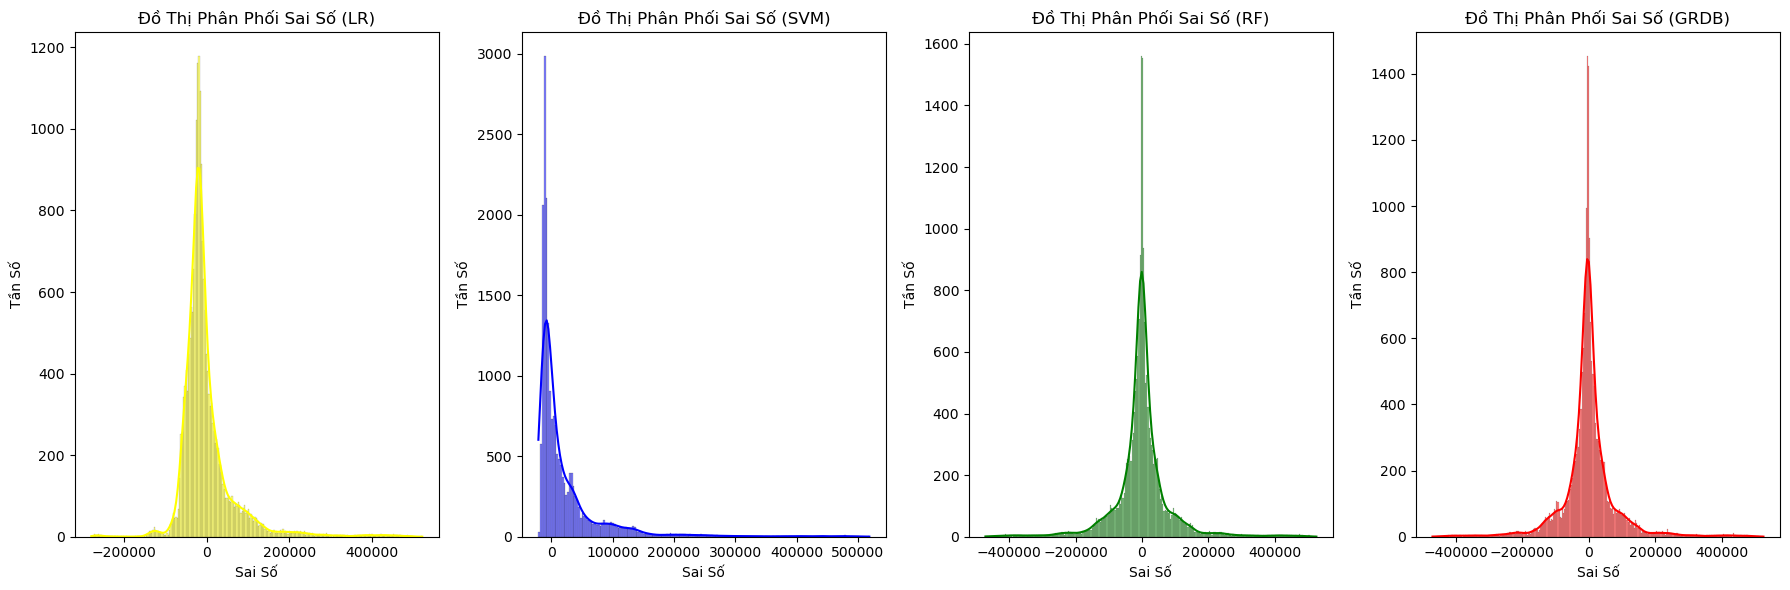

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


residuals_svm = y_test - y_pred_svm
residuals_rf = y_test - y_pred_rf
residuals_grdb = y_test - y_pred_grdb
residuals_lin = y_test - y_pred_lin

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
sns.histplot(residuals_lin, kde=True, color='yellow')
plt.xlabel('Sai Số')
plt.ylabel('Tần Số')
plt.title('Đồ Thị Phân Phối Sai Số (LR)')

plt.subplot(1, 4, 2)
sns.histplot(residuals_svm, kde=True, color='blue')
plt.xlabel('Sai Số')
plt.ylabel('Tần Số')
plt.title('Đồ Thị Phân Phối Sai Số (SVM)')

plt.subplot(1, 4, 3)  
sns.histplot(residuals_rf, kde=True, color='green')  
plt.xlabel('Sai Số')
plt.ylabel('Tần Số')
plt.title('Đồ Thị Phân Phối Sai Số (RF)')

plt.subplot(1, 4, 4)  
sns.histplot(residuals_grdb, kde=True, color='red')  
plt.xlabel('Sai Số')
plt.ylabel('Tần Số')
plt.title('Đồ Thị Phân Phối Sai Số (GRDB)')

plt.tight_layout()
plt.show()